# Segmentation of mammo tiles

In [41]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [42]:
#from fastai.core import *
from fastai import *
from fastai.vision import *
import PIL

from pathlib import *
import pandas as pd
import numpy as np
import colorcet as cc

#from gray_image import *
from fastai_gs import *

cmap_grey = cc.cm.linear_grey_0_100_c0

In [43]:
from enum import Enum
class ObsType(Enum):
    EMPTY=0           ,"empty"                   # outside the breast
    NORMAL=1          ,"normal"                  # tissue with no segments
    BENIGN_CALC=2     ,"benign_calcification"    # tissue with benign calcification
    MALIGNANT_CALC=3  ,"malignant calcification"  # tissue with malignant calcification
    BENIGN_MASS=4     ,"benign_mass"              # tissue with a benign node
    MALIGNANT_MASS=5  ,"malignant mass"           # tissue with a malignant node
def enum2int(e): return e.value[0]

def selectCases( cases, purpose, complexity, nb=1000 ): 
    dfAll = None
    for k,q in complexity.items():
        df  = cases[cases.purpose==purpose].query(q)
        df["classes"] = k
        idx   = np.unique(np.random.uniform( low=0, high=df.shape[0], size=10*nb).astype(int))
        idx   = idx[0:min(df.shape[0], nb, len(idx) )]
        dfAll = dfAll.append(df.iloc[idx]) if dfAll is not None else df.iloc[idx]
    return dfAll
 

In [44]:
path  = Path('../../data/mammography-data/mammography-dogscats-match-equalization-BINS-CHX/tiles') #print(list(path.iterdir()))
dxrays = "xrays"
dmasks = "obs_masks"
dtrain = "train"
dvalid = "test"

In [45]:
cases = pd.read_csv( path / "tiles.csv", sep=";", low_memory=False)
cases.drop("Unnamed: 0",axis=1,inplace=True)
#print(f"cases.columns:{cases.columns}")
#display(cases.tail(2))

#print("Stat of dataset before selection")
#gp = cases.groupby( ["purpose", "observation", "simple_pathology"])["fnImage"].count()
#print( gp )

codes = [obs.name.lower() for obs in ObsType]
#print(f"codes:{codes}")

complexity={
            "malignant_calc":"malignant_calc > 0.3*obsAreas and empty < 0.05*tile_size",
            "benign_calc":   "benign_calc    > 0.3*obsAreas and empty < 0.05*tile_size",
            "malignant_mass":"malignant_mass > 0.3*obsAreas and empty < 0.05*tile_size",
            "benign_mass":   "benign_mass    > 0.3*obsAreas and empty < 0.05*tile_size"
}
nb=1700

test   = selectCases( cases, "test",  complexity=complexity, nb=nb//2 )
train  = selectCases( cases, "train", complexity=complexity, nb=nb )
dfData = test.append(train)
print("Selected dataset"), display(dfData.head())
gp = dfData.groupby( ["purpose", "observation", "classes"])["fnImage"].count()
display( gp )


Selected dataset


,case_id,height,width,simple_pathology,patient_id,purpose,density,left_right,projection,obs id,...,malignant_calc,benign_mass,malignant_mass,rCenter,cCenter,tile_size,obsAreas,fnImage,fnMask,classes
131,Calc-Test_P_00127_RIGHT_CC,5375,2882,MALIGNANT,P_00127,test,2.000,RIGHT,CC,1,...,35066,0,0,0.550,0.460,1048576,48236,Calc-Test_P_00127_RIGHT_CC_tile_2435_809.png,Calc-Test_P_00127_RIGHT_CC_tile_2435_809.png,malignant_calc
132,Calc-Test_P_00127_RIGHT_CC,5375,2882,MALIGNANT,P_00127,test,2.000,RIGHT,CC,1,...,48709,0,0,0.590,0.620,1048576,48236,Calc-Test_P_00127_RIGHT_CC_tile_2670_1289.png,Calc-Test_P_00127_RIGHT_CC_tile_2670_1289.png,malignant_calc
133,Calc-Test_P_00127_RIGHT_CC,5375,2882,MALIGNANT,P_00127,test,2.000,RIGHT,CC,1,...,48460,0,0,0.640,0.400,1048576,48236,Calc-Test_P_00127_RIGHT_CC_tile_2918_628.png,Calc-Test_P_00127_RIGHT_CC_tile_2918_628.png,malignant_calc
146,Calc-Test_P_00127_RIGHT_MLO,5669,2615,MALIGNANT,P_00127,test,2.000,RIGHT,MLO,1,...,23367,0,0,0.850,0.500,1048576,41836,Calc-Test_P_00127_RIGHT_MLO_tile_4301_806.png,Calc-Test_P_00127_RIGHT_MLO_tile_4301_806.png,malignant_calc
147,Calc-Test_P_00127_RIGHT_MLO,5669,2615,MALIGNANT,P_00127,test,2.000,RIGHT,MLO,1,...,42245,0,0,0.750,0.490,1048576,41836,Calc-Test_P_00127_RIGHT_MLO_tile_3733_758.png,Calc-Test_P_00127_RIGHT_MLO_tile_3733_758.png,malignant_calc


purpose  observation    classes       
test     calcification  benign_calc        420
                        malignant_calc     261
         mass           benign_mass        673
                        malignant_mass     441
train    calcification  benign_calc       1700
                        malignant_calc    1156
         mass           benign_mass       1700
                        malignant_mass    1700
Name: fnImage, dtype: int64

In [46]:
#calculate the weights of the classes in the loss function
minWeight = 0
gp = dfData.groupby(["purpose"])[codes].mean().astype(np.int)

s = gp.sum(axis=1)
gp.iloc[0] /= s.iloc[0]
gp.iloc[1] /= s.iloc[1]

pd.options.display.float_format = '{:,.3f}'.format
print("Frequency of pixel pr class codes"), display(gp)

code_weights = 1. / (gp+1e-6)
code_weights[gp==0] = 0

s = code_weights.sum(axis=1)
code_weights.iloc[0] /= s.iloc[0]
code_weights.iloc[1] /= s.iloc[1]

print(f"\nWeights of observations")
display(code_weights)

#use the weight for training
code_weights = code_weights.iloc[0].values
#code_weights = code_weights**0.95
#code_weights /= np.sum(code_weights)
code_weights[code_weights==0] = minWeight

n=gc.collect()

Frequency of pixel pr class codes


,empty,normal,benign_calc,malignant_calc,benign_mass,malignant_mass
purpose,,,,,,
test,0.006,0.910,0.016,0.027,0.023,0.018
train,0.006,0.897,0.020,0.036,0.016,0.025



Weights of observations


,empty,normal,benign_calc,malignant_calc,benign_mass,malignant_mass
purpose,,,,,,
test,0.449,0.003,0.168,0.103,0.120,0.157
train,0.480,0.003,0.145,0.081,0.179,0.113


In [47]:
#np.exp(code_weights)-1
#code_weights[3]=0
code_weights

array([0.448717, 0.003049, 0.168137, 0.10334 , 0.119562, 0.157196])

In [48]:
ixTrain  = dfData.purpose=="train"
ixValid  = ixTrain == False

train  = join_paths(dfData.fnImage[ixTrain].values, path/dtrain/dxrays)
valid  = join_paths(dfData.fnImage[ixValid].values, path/dvalid/dxrays)

get_y_fn   = lambda x: x.parents[1]/dmasks/x.name 
valid_func = lambda x: x.parts[-3] == dvalid

def open_image_16bit2rgb( fn, div:bool=True, convert_mode:str='RGB', cls:type=Image): 
    if convert_mode=="RGB":
        a  = np.asarray(PIL.Image.open( fn ))
        a  = np.expand_dims(a,axis=2)
        a  = np.repeat(a, 3, axis=2)
        im = pil2tensor(a, np.float32 )
        if div: im.div_(65535) 
    elif convert_mode=="L":
        a  = np.asarray( PIL.Image.open( fn ).convert(convert_mode) )
        im = pil2tensor(a, np.float32 ) 
        if div: im.div_(255) 
    return Image( im )

vision.data.open_image = open_image_16bit2rgb

src = (SegmentationItemList( list(train+valid), create_func=open_image_16bit2rgb, path="")
                           .split_by_valid_func(valid_func)
                           .label_from_func(get_y_fn, classes=codes)           
      )

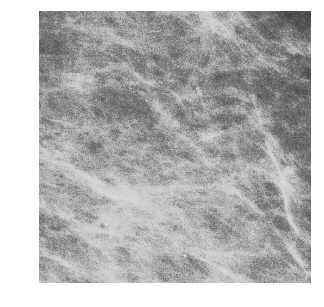

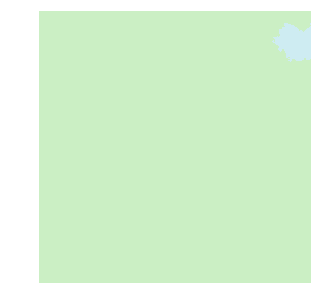

In [49]:
files = list((path/dvalid/dxrays).iterdir())
r     = dfData.iloc[-11]
fn_im = path/(dtrain if r.purpose=="train" else dvalid)/dxrays/r.fnImage
im    = open_image_16bit2rgb(fn_im)
show_image( im, figsize=(5,5) ), plt.show()

fn_msk = path / (dtrain if r.purpose=="train" else dvalid)/dmasks/r.fnImage
mask   = open_mask(fn_msk)
mask.show(figsize=(5,5), cmap="tab20", alpha=.5)

In [50]:
def getSegmentationTransforms():
    max_zoom        = 1.1
    max_rotate      = 0.1
    brightnes_range = (0.95, 1.)
    contrast_range  = (0.95, 1.)
    rotate_range    = (-10, 10) # degrees
    warp_range      = (-0.1, 0.1)
    
    tfmTrain,tfmValid =[],[]
    
    tfmTrain.append(crop_pad())
    tfmTrain.append( dihedral_affine() )
    
    
    tfmTrain.append( rotate(degrees=rotate_range, p=.5) )
    """
    tfmTrain.append( symmetric_warp(magnitude=warp_range, p=0.5) )
    tfmTrain.append( rand_zoom(scale=(1.,max_zoom), p=0.75) )
    #tfmTrain.append( flip_affine(p=0.5) )
    
    #tfmTrain.append( skew( np.arange, p=0.75) )
    #tfmTrain.append( perspective_warp(magnitude=warp_range, p=0.25) )
    
    #tfmTrain.append( rand_zoom(scale=(1.,max_zoom), p=0.75) )
    #tfmTrain.append( rand_crop() )

    tfmTrain.append( jitter(magnitude=0.01) )
    
    tfmTrain.append( jitter(magnitude=0.001) )
    if brightnes_range is not None: tfmTrain.append( brightness(change=brightnes_range, p=0.25) )
    if contrast_range is not None:  tfmTrain.append( contrast(scale=contrast_range,     p=0.25) )
    """
    
        
    tfmValid.append(crop_pad())
    #tfmValid.append( flip_affine(p=0.5) )
    return (tfmTrain, tfmValid)

In [51]:
class ACC:          
    class_mask = torch.from_numpy( (code_weights > 0).astype(np.float32) )
    @staticmethod
    def accuracy_seg(input, target):
        #The input.argmax(dim=1) selects the winner class pr pixel, thereby reducing 
        #the input shape from (bs, classes, width, height) => (bs, width, height)
        #We, therefore, have to reshape the target tensor from (bs, 1, width, height) to (bs, width, height)
        sz     = target.size()
        target = target.reshape( (sz[0], sz[2], sz[3]) )

        #mask out classes with zeri weight
        if ACC.class_mask.lt(0).any() :
            mask = None
            for i in range(len(ACC.class_mask)):
                if ACC.class_mask[i] <= 0:
                    mask = target.eq(i).byte() if mask is None else mask + target.eq(i).byte()
                
            mask = mask.eq(0)
            return (input.argmax(dim=1)[mask].flatten()==target[mask].flatten()).float().mean()        #mask   = mask.reshape( (sz[0], sz[2], sz[3]) )
        else:
            return (input.argmax(dim=1).flatten()==target.flatten()).float().mean()

In [52]:
#ix_codes = torch.from_numpy( np.asarray( np.where(code_weights>0) ).flatten().astype(np.long) ).long().cuda()
#print(ix_codes)
#def ignoreImageValues( class_images, class_mask, value=0):
#    "set the pixel class to an ignore_index if the weight of the class is zero"
#    for i in range(len(class_mask)):
#        if class_mask[i] <= 0. :
#            class_images[class_images==i] = value


class WeighedCrossEntropy(nn.Module):
    msgBefore=""
    msgAfter=""
    msgRes=""
    msg=""
    class_losses = []
    idx=0
    bs_loss = []
    loss = None
    input=None
    target=None
    def __init__( self, code_weights ):
        super(WeighedCrossEntropy, self).__init__()
        self.register_buffer("class_weights",  torch.from_numpy( code_weights).cuda() )
        self.register_buffer("ix_weights", torch.from_numpy( (code_weights>0).flatten().astype(np.float32) ) )
        self.ignore_index = -1
        WeighedCrossEntropy.class_losses=[]
        
    def forward(self, input:Tensor, target:Tensor) -> Rank0Tensor:
        scale  = 0.01
        #w      = torch_weigths_mult_noise(scale, self.weights )
        
        #WeighedCrossEntropy.msgAfter  = f"after: { input.size()}"
        #ignoreImageValues(target, ACC.class_mask, self.ignore_index )
        sz = target.shape
        target = target.reshape(sz[0],sz[2],sz[3])
        for i in range( self.ix_weights.shape[0] ) :
            if self.ix_weights[i] <= 0 : target[target==i] = self.ignore_index
        
        WeighedCrossEntropy.input  = input.clone().cpu()
        WeighedCrossEntropy.target = target.clone().cpu()
        
        n,c,rows,cols = input.shape
        loss = F.cross_entropy(input, target, ignore_index=self.ignore_index, reduction = "none" )
        WeighedCrossEntropy.loss   = loss.clone().cpu()
        batch_loss = batch_loss_n = 0.
        for i in range(c):
            ix = target==i
            s  = ix.sum()
            #WeighedCrossEntropy.msg = f"{input.shape} - {target.shape} - {loss.shape} - {ix.shape}"
            
            if s>1:
                m             = loss[ix].mean().pow(2)
                #sd            = loss[ix].std()
                batch_loss   += m #+sd
                batch_loss_n += 1
            elif s==1:                
                m             = loss[ix].mean().pow(2)
                #sd            = 0
                batch_loss   += m
                batch_loss_n += 1
                
            #if s>0:WeighedCrossEntropy.class_losses.append( (WeighedCrossEntropy.idx, i, s, np.round(m, 4), np.round(sd,4) ) )
            #WeighedCrossEntropy.idx += 1

        if batch_loss > 0: 
            batch_loss /= batch_loss_n
        #WeighedCrossEntropy.bs_loss.append(batch_loss)    
        WeighedCrossEntropy.bs_loss=batch_loss
        
        return batch_loss
    

In [53]:
class CrossEntropyBuckets(nn.Module):
    def __init__( self, alfa=0.1, prClassLoss=True ):
        super(CrossEntropyBuckets, self).__init__()
        self.alfa=alfa
        self.prClassLoss=prClassLoss
        #self.register_buffer("classOpt",  torch.from_numpy( np.asarray([classOpt]).astype(np.int32) ).byte().cuda() )
        
    def forward(self, x:Tensor, y:Tensor) -> Rank0Tensor:
        bs, nc, cols, rows = x.size()
        xv         = x.permute(0, 2, 3, 1)        #bs,cols,rows, nc
        xv         = xv.contiguous().view(-1, nc) #bs*cols*rows, nc
        yv         = y.view(-1)
    
        xv_argmax  = xv.argmax(dim=1)
        ix_error   = xv_argmax.ne(yv)
        xv         = F.cross_entropy(xv, yv, reduction = "none" )
    
        if self.prClassLoss is False:
            error_loss = xv[ix_error].mean()
            mean_loss  = xv.mean()
            return error_loss*(1-self.alfa) + self.alfa*mean_loss
        else:
            m_mc=m_ac=count_c=0.
            over_th = xv.gt(.5)
            for i in range(nc):
                #mc: misclassified from class
                #ac: all from class
                ix_mc    = ( (yv==i) + (ix_error==1) + over_th).eq(3)
                ix_ac    = yv.eq(i)
                ix_mc_sum= ix_mc.sum()
                ix_ac_sum= ix_ac.sum()
            
                m_mc     += xv[ix_mc].mean() if ix_mc_sum>0 else 0.
                m_ac     += xv[ix_ac].mean() if ix_ac_sum>0 else 0.
                count_c  += 1                if ix_ac_sum>0 else 0.
            
            return (m_mc*(1-self.alfa) + m_ac*self.alfa) / count_c
       

In [54]:
class FocalLoss(nn.Module):
    def __init__( self, gamma=2., prClassLoss=True ):
        super(FocalLoss, self).__init__()
        self.gamma=gamma
        self.prClassLoss=prClassLoss
        
    def forward(self, x:Tensor, y:Tensor) -> Rank0Tensor:
        
        bs, nc, cols, rows = x.size()
        xv         = x.permute(0, 2, 3, 1)        #bs,cols,rows, nc
        xv         = xv.contiguous().view(-1, nc) #bs*cols*rows, nc
        yv         = y.view(-1,1)
        
        #its numerically more stable and faster to do log_softmax in 1 operation 
        xv         = F.log_softmax(xv, dim=1)
        #get logsoftmax for the pixel class
        y_lsm      = torch.gather(xv, 1, yv)
        #get the probability for the pixel class
        y_prob     = y_lsm.exp()
        
        #gamma weighting so well classified pixel gets less influence 
        y_prob_w   = (1-y_prob)**self.gamma      
        y_loss     = -y_prob_w * y_lsm
        
        if self.prClassLoss is False:
            return y_loss.mean() / y_prob_w.mean()
        else:
            yv  = y.view(-1)
            #pgt = y_prob.view(-1).gt(.5)
            
            m=count_c=0.
            for i in range(nc):
                ix      = yv.eq(i)
                ix_sum  = ix.sum()
            
                m       += y_loss[ix].mean() if ix_sum>0 else 0.
                count_c += 1                 if ix_sum>0 else 0.
            
            return m / count_c #/ y_prob_w.mean()
            

In [55]:
class DiceLoss(nn.Module):
    #smooth=0.
    #l1norm=True  => denominator is den1+den2. 
    #l1norm=False => denominator is den1**2+den2**2
    # prClassLoss=True  => dice is calculated pr class and average over classes
    # prClassLoss=True  => dice for each is scaled proportionaly to its frequency. 
    #                      ie same as making the dice wtíthout breaking it down into classes
    def __init__( self, smooth=0., l1norm=True, prClassLoss=True ):
        super(DiceLoss, self).__init__()
        self.smooth=smooth
        self.l1norm=l1norm
        self.prClassLoss=prClassLoss

    def forward(self, x:Tensor, y:Tensor) -> Rank0Tensor:
        eps = 1e-6
        
        bs, nc, cols, rows = x.size()
        xp   = x.permute(0, 2, 3, 1)
        xp   = xp.contiguous().view(-1, nc)
        xp   = xp.softmax(dim=1)
    
        #make one hot encoding
        yp   = y.view(-1)
        ix   = torch.arange(len(yp))
        yhot = torch.zeros_like(xp)
        yhot[ix,yp[ix]] = 1.
    
        #build nominator and denominators and reduce to number of classes
        num  = (xp*yhot).sum(dim=0)
        den1 = xp.sum(dim=0)   if self.l1norm else (xp*xp).sum(dim=0)
        den2 = yhot.sum(dim=0) if self.l1norm else (yhot*yhot).sum(dim=0)
        
        dice = (2.*num)/(den1 + den2 + eps)
        
        #if self.prClassLoss then divide by mumber of nonempty classes else
        # when global loss then scale the influence of each class dice proportionaly to its frequency
        if self.prClassLoss : 
            dice = dice / (dice.gt(0.).sum().float()+eps) 
        else:         
            count = yhot.sum(dim=0)
            dice  = dice * (count/(count.sum()+eps))

        return 1. - dice.sum()
    

In [56]:
def printWithDec(v,title=None,d=2): 
    with np.printoptions(precision=d, suppress=True): 
        if title is None : print(v.numpy())
        else: print(f"{title}:", v.detach().numpy())
#WeighedCrossEntropy.bs_loss
#print(WeighedCrossEntropy.msg)
#WeighedCrossEntropy.class_losses
if WeighedCrossEntropy.loss is not None: 
    np.save( path/"input.npy",  WeighedCrossEntropy.input )
    np.save( path/"target.npy", WeighedCrossEntropy.target )
    np.save( path/"loss.npy",   WeighedCrossEntropy.loss )
    print(WeighedCrossEntropy.loss.shape)
    printWithDec(WeighedCrossEntropy.loss[0], "loss",2)
    print("bs_loss",WeighedCrossEntropy.bs_loss)
    print("loss.shape", WeighedCrossEntropy.loss.size())
    print("loss[-1].shape", WeighedCrossEntropy.loss[-1])

In [57]:
#bs,size=100,64
#bs,size=32,128
#bs,size=64,128 
#bs,size=16,128 
bs,size=16,256 
#bs,size=4,512 
data = ( src.transform(getSegmentationTransforms(), size=size, tfm_y=True)
            .databunch(bs=bs)
            .normalize(imagenet_stats) )
#data.show_batch(2, figsize=(10,7))

In [58]:
#loss_func = WeighedCrossEntropy( code_weights.astype(np.float32) ) # DiceLoss() #WeighedCrossEntropy( code_weights.astype(np.float32) ) # # FocalLoss(gamma=2.,alpha=.25), #  
#loss_func = CrossEntropyBuckets(alfa=0.05)
#loss_func = FocalLoss(gamma=2., prClassLoss=True)
loss_func = DiceLoss(l1norm=True,  prClassLoss=True)
wd=1e-2
learn =unet_learner(data, 
                    models.resnet34, 
                    metrics=ACC.accuracy_seg,
                    loss_func= loss_func,
                    wd=wd,
                    #blur_final=False
                    )


In [59]:
n = gc.collect()
torch.cuda.empty_cache()
#lr_find(learn,end_lr=10)
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


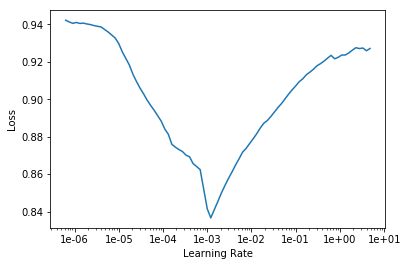

In [60]:
learn.recorder.plot(skip_end=3)

In [61]:
lr=0.5e-3
moms=(0.97,0.87)
learn.fit_one_cycle(6, slice(lr), moms = moms )
n=gc.collect()
torch.cuda.empty_cache()

epoch,train_loss,valid_loss,accuracy_seg
1,0.637220,0.344430,0.868086
2,0.589728,0.342722,0.802203
3,0.552432,0.292527,0.884650
4,0.527024,0.280006,0.896175
5,0.511031,0.268705,0.883487
6,0.498966,0.268849,0.885158


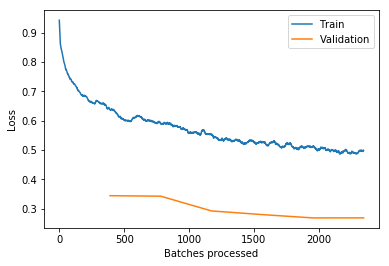

In [62]:
learn.recorder.plot_losses()

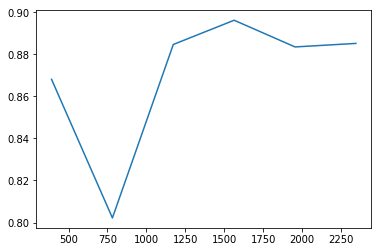

In [63]:
learn.recorder.plot_metrics()

In [64]:
learn.opt.wd

0.01

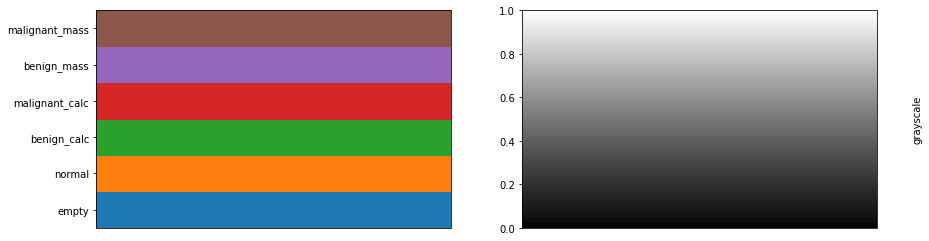

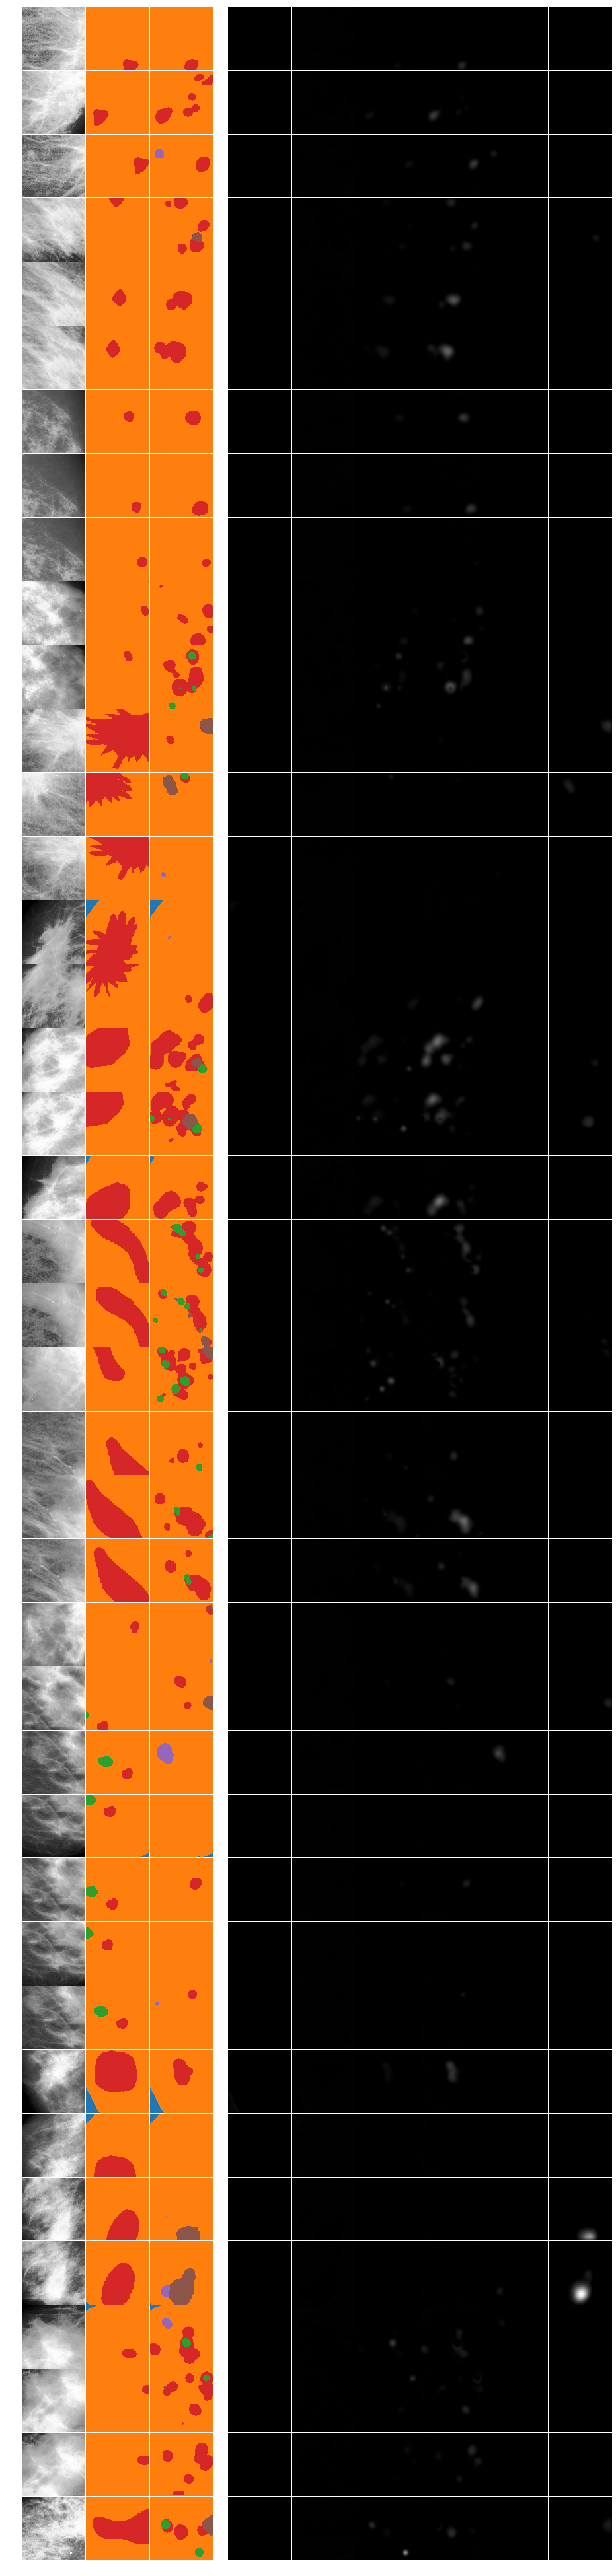

In [65]:
plotPreds(learn, nrows=40, codes=codes, code_weights=code_weights, ds_type=DatasetType.Valid)  

In [66]:
xs,ys,ps,pcs = getIO(learn, 1, ds_type=DatasetType.Train, class_mask=code_weights)

In [67]:
print(pcs[0].min())
print(pcs[0].max())

-1027.529
1713.5419


In [68]:
learn.save('resnet34-stage-1')
n=gc.collect()
torch.cuda.empty_cache()

In [69]:
learn.load('resnet34-stage-1');

In [70]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


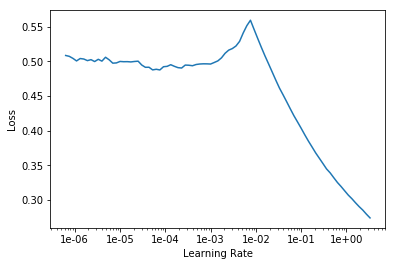

In [71]:
lr_find(learn)
learn.recorder.plot()

In [72]:
multilayer_lr=slice(1e-6,lr/5)
learn.fit_one_cycle(12, multilayer_lr, moms=moms)

epoch,train_loss,valid_loss,accuracy_seg
1,0.489853,0.269154,0.895539
2,0.495413,0.271328,0.902085
3,0.484172,0.267866,0.891948
4,0.492157,0.271594,0.900827
5,0.485831,0.268575,0.881379
6,0.481483,0.262210,0.897167
7,0.473498,0.264312,0.890326
8,0.462892,0.257805,0.902416
9,0.459280,0.257869,0.891957
10,0.463792,0.259055,0.903737


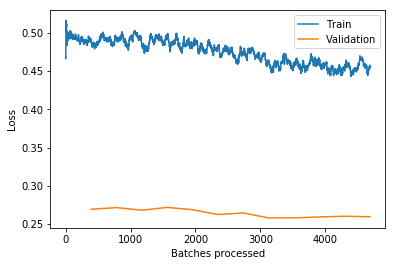

(None, None, None)

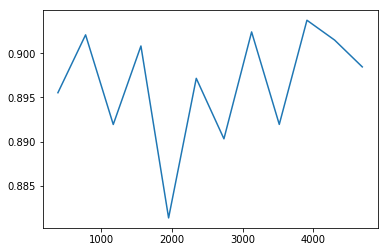

In [73]:
learn.recorder.plot_losses(), plt.show(), learn.recorder.plot_metrics()

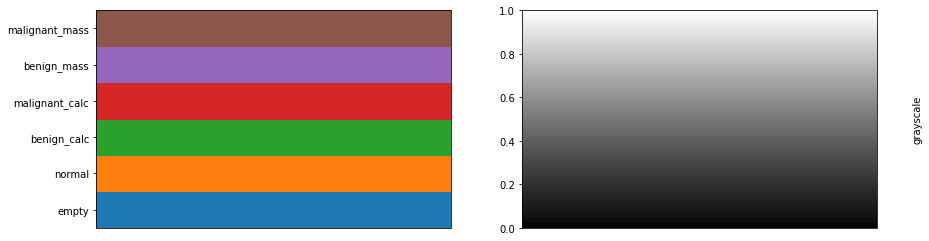

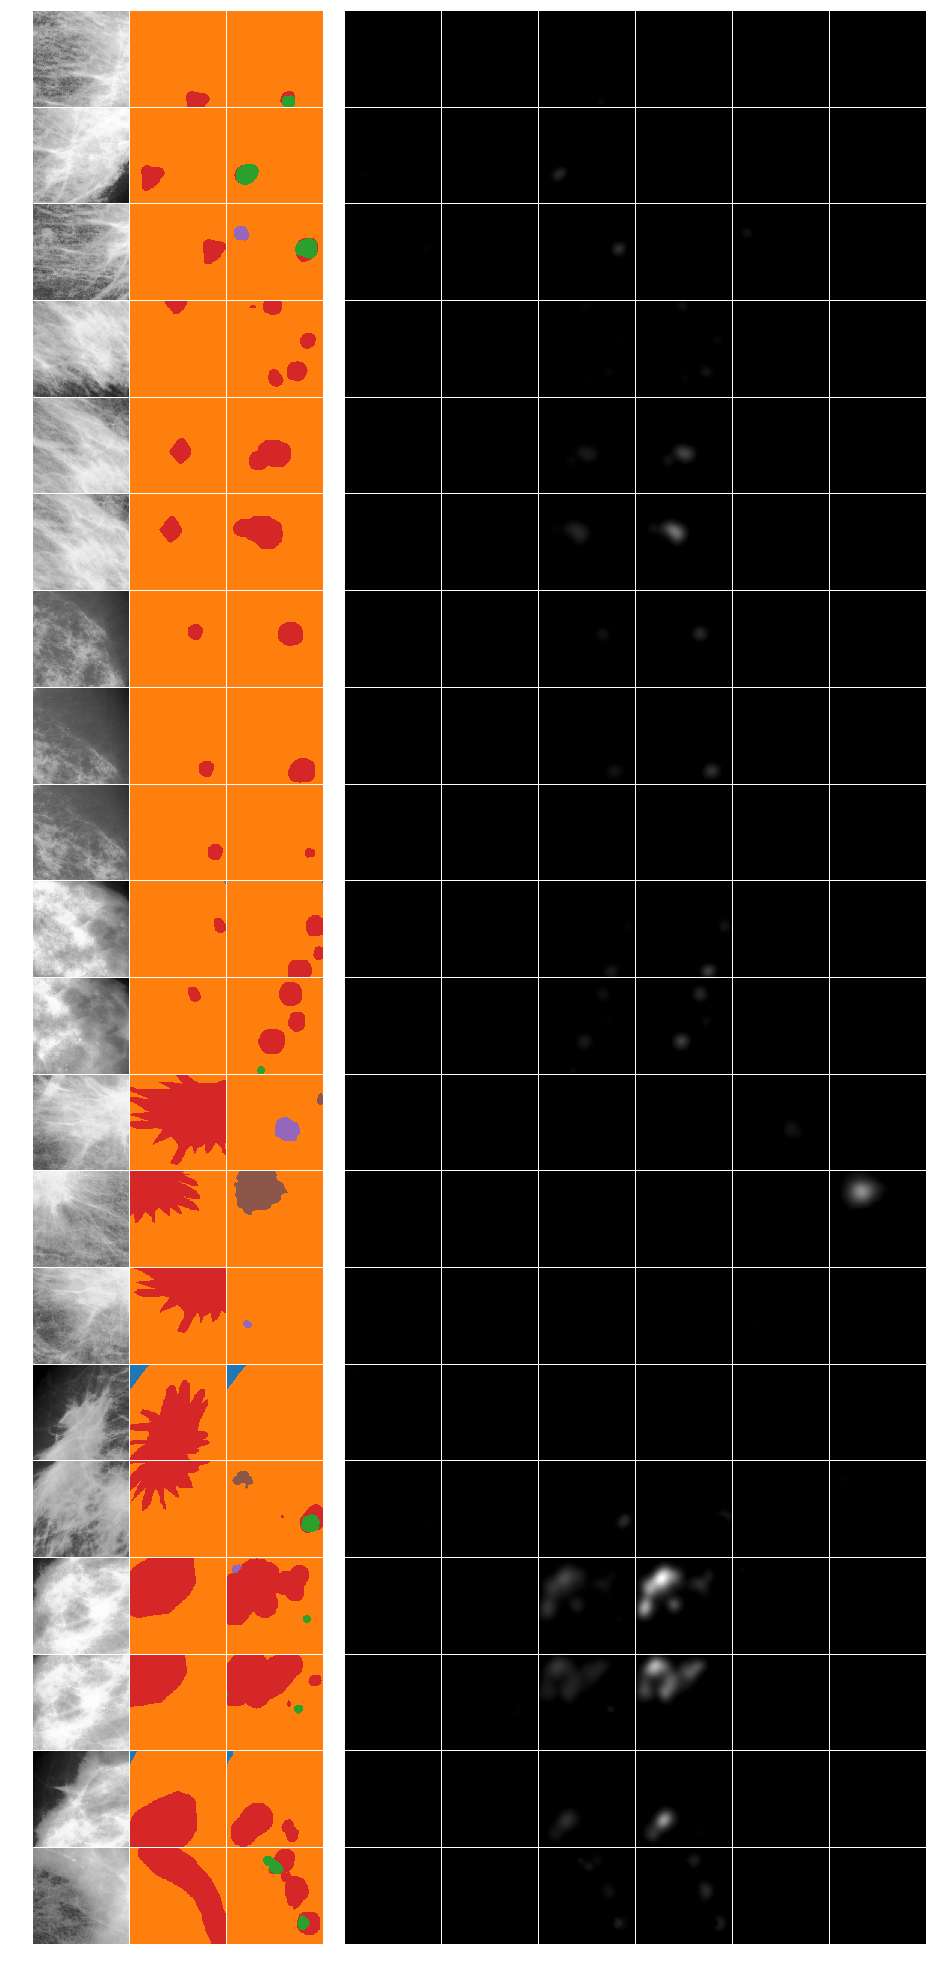

In [74]:
plotPreds(learn, nrows=20, codes=codes, code_weights=code_weights, ds_type=DatasetType.Valid)   

In [75]:
xs,ys,ps,pcs = getIO(learn, 1, ds_type=DatasetType.Train, class_mask=code_weights)

In [76]:
print(pcs[0].min())
print(pcs[0].max())

-3080.3384
4141.6426


In [77]:
learn.save('resnet34-stage-2');